In [74]:
from google.colab import drive
drive.mount('/content/drive')
train_b=False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model

In [76]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])*float(y_test[i]-y_pred[i]) for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RRMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    n = [float(y_test[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/sum(n))          
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [77]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [78]:
data = []
#for y in range(2017,2023):
for y in [2021]:
  df = pd.read_csv(f"{DATA_DIR}/Total_Data_{y}_5m.csv")
  data.append(df)
data = pd.concat(data)
print(data.head(20).to_string())

used_var = ['N.Y.C.']

data = data[used_var].backfill();
data = data.dropna(how='any')

for c in used_var:
  #print(data[c].head(15));
  print(c,len(data[c].index),data[c].mean(),data[c].std())

n = len(data.index)
t = int(7*24*(60/5))
num_var = len(used_var)

             Unnamed: 0     CAPITL     CENTRL    DUNWOD     GENESE     HUD VL     LONGIL    MHK VL    MILLWD     N.Y.C.     NORTH       WEST        NYCA  Global Horizontal UV Irradiance (280-400nm)  Global Horizontal UV Irradiance (295-385nm)  HourlyDryBulbTemperature  HourlyRelativeHumidity
0   2021-01-01 00:00:00  1253.6528  1646.5823  602.6414  1009.6906  1031.5640  2128.3490  861.0112  344.1649  4915.3086  643.6438  1574.9854  16011.5940                                          0.0                                          0.0                 34.700000               64.900000
1   2021-01-01 00:05:00  1261.2753  1675.9110  602.1752   999.1802  1021.9031  2126.8270  849.0410  344.4898  4892.8174  644.0825  1568.2175  15985.9200                                          0.0                                          0.0                 34.533333               65.400000
2   2021-01-01 00:10:00  1238.2727  1660.6127  608.2949   997.9413  1014.6226  2089.7195  849.0281  336.7801  4868.1533  

In [79]:
m = 5687.832418083788
std = 1185.1401264331366

m_s = -3.78815163514314e-05
std_s = 16.78856791915454

m_list=[m]
std_list=[std]

def untransform_dataset_old(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    dataset=dataset.reshape(nv,ns*tw)
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=3):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[0]-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].T
    dataX.append(a)
    
    e = dataset[i + hist_window:  i + hist_window+forecast_window, 0]
    dataY.append(e)
  return np.array(dataX), np.array(dataY)

def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==2:
    #ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    ns,nv = s
    dataset=dataset.T 
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.T 
  else:
    dataset=(dataset-mi[0])/stdi[0] 
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  dataset=(dataset*stdi[0])+mi[0]
  return dataset  
    
  return np.array(dataX), np.array(dataY)
dataset = data[used_var].values
dataset_xfr = transform_dataset(dataset)

x,y = create_dataset_mult(dataset_xfr,hist_window,forecast_window,num_var)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

In [80]:
## reshape input to be [samples, time steps, features]
#train = np.reshape(train, (train.shape[0], 1, train.shape[1]))
##x_train = x_train.reshape(-1, 28, 28, 1)
#print(train.shape)
#valid = np.reshape(valid, (valid.shape[0], 1, valid.shape[1]))
#print(valid.shape)

#Build Model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 4)                 368       
                                                                 
 dense_6 (Dense)             (None, 18)                90        
                                                                 
Total params: 458
Trainable params: 458
Non-trainable params: 0
_________________________________________________________________


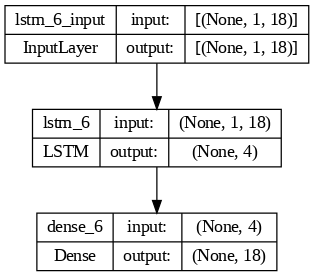

In [81]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Test"
def create_LSTM_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005,var_num = 1,
                      hist_window=18,forecast_window=18):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(var_num, hist_window)))
    model.add(Dense(forecast_window))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model()
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [82]:
#Fit Model
model_name = 'test_model_vector.h5'
print(datetime.datetime.now())
print(datetime.datetime.now())
if train_b:
  model.fit(train, label_t, epochs=5, batch_size=1, verbose=2)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-03-01 00:20:44.348231
2023-03-01 00:20:44.349609


62/62 [==============================] - 0s 5ms/step
Total Test Score: 312.16 RMSE
90 Min Test Score: 115.55 RMSE
Relative Test Score: 2.27 perc RMSE


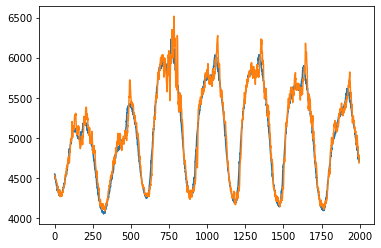

In [85]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict(valid)

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()

In [86]:


# 90 minutes